### Version 1 : Simple Random Forest for original dataset


Model Evaluation:
Accuracy: 0.2642
Precision (weighted): 0.2484
Recall (weighted): 0.2642
F1-score (weighted): 0.2456
ROC AUC Score: 0.9396


c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Cross-validation scores: [0.20305481 0.23989218 0.21582734 0.19694245 0.23201439]
Mean CV score: 0.2175 (+/- 0.0328)

Classification Report:
               precision    recall  f1-score   support

     Abundant       0.20      0.17      0.18         6
       Active       0.00      0.00      0.00         6
        Adult       0.00      0.00      0.00         2
        Agile       0.09      0.14      0.11         7
     Alluring       0.38      0.45      0.42        11
      Amiable       0.09      0.20      0.12         5
      Amusing       0.33      0.17      0.22         6
      Aqueous       0.00      0.00      0.00         4
 Aristocratic       0.00      0.00      0.00         4
     Aromatic       0.00      0.00      0.00         5
     Artistic       0.00      0.00      0.00         1
Authoritative       0.00      0.00      0.00         4
       Bitter       0.67      0.50      0.57         4
      Bitterl       0.00      0.00      0.00         1
         Bold       0.00      0.

c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


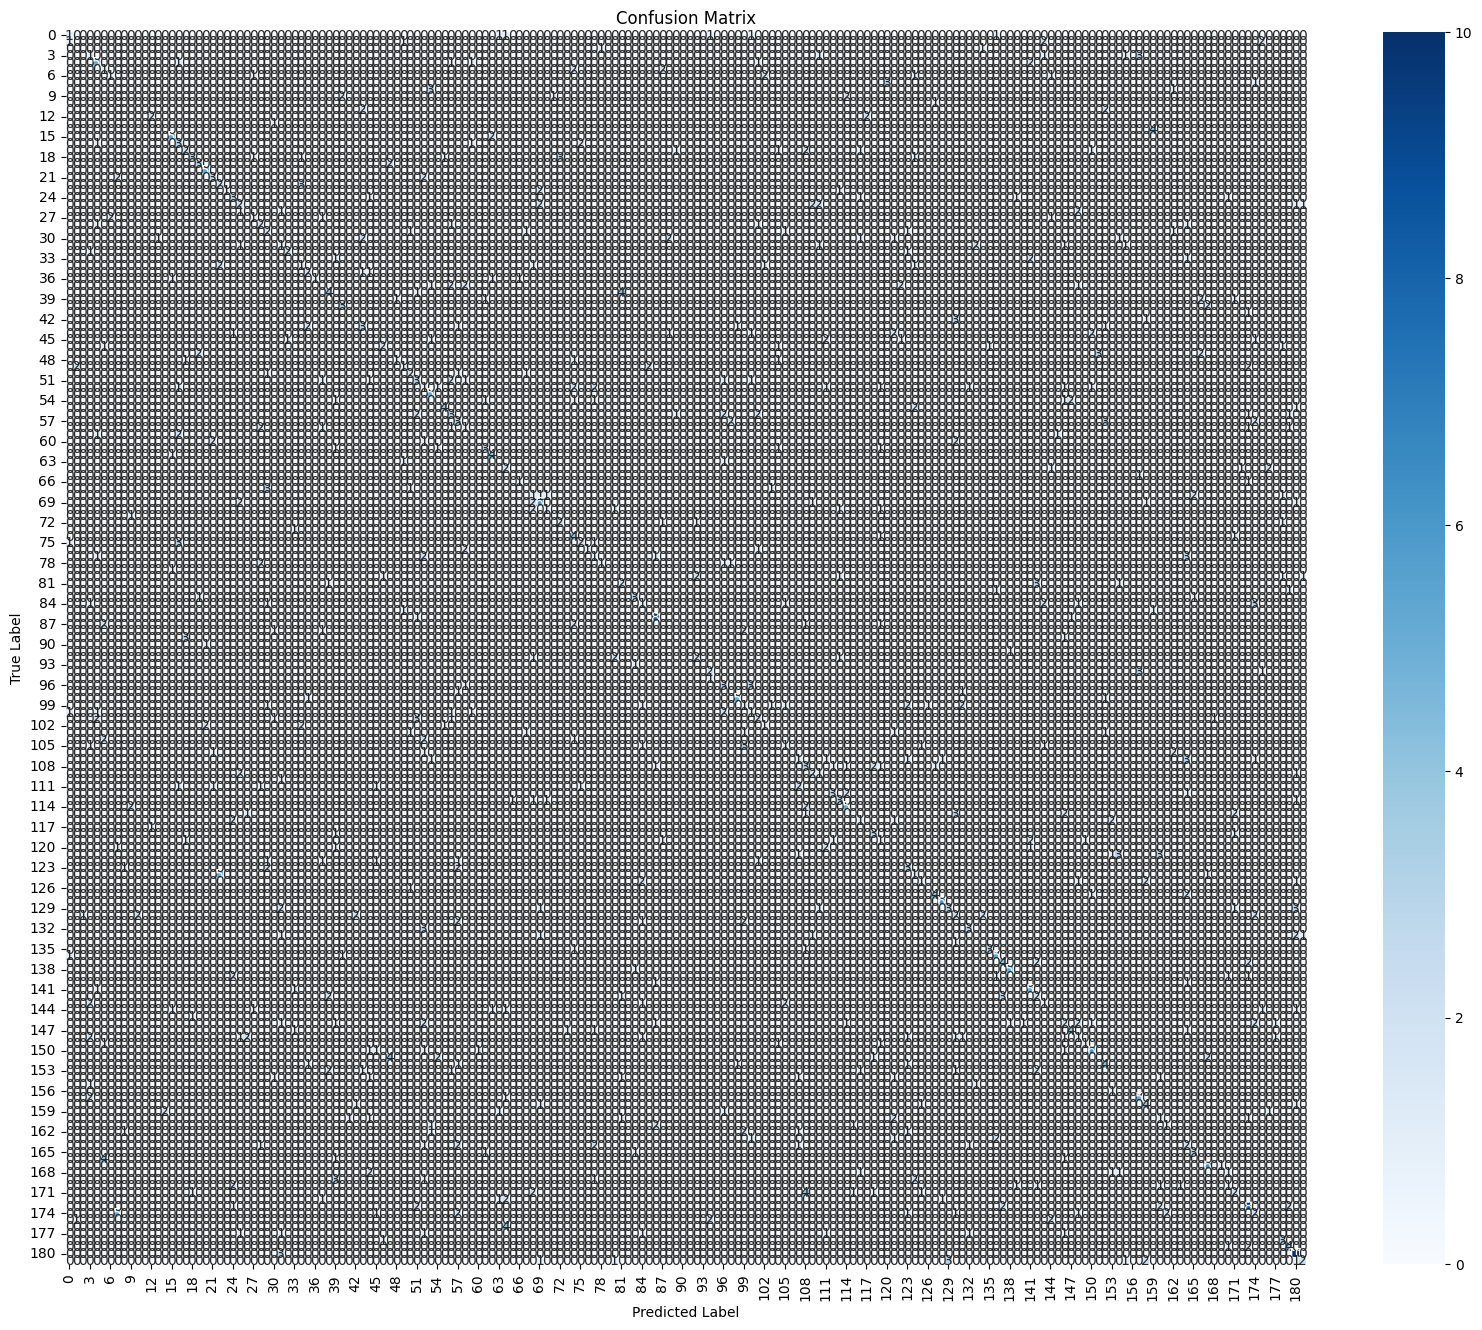

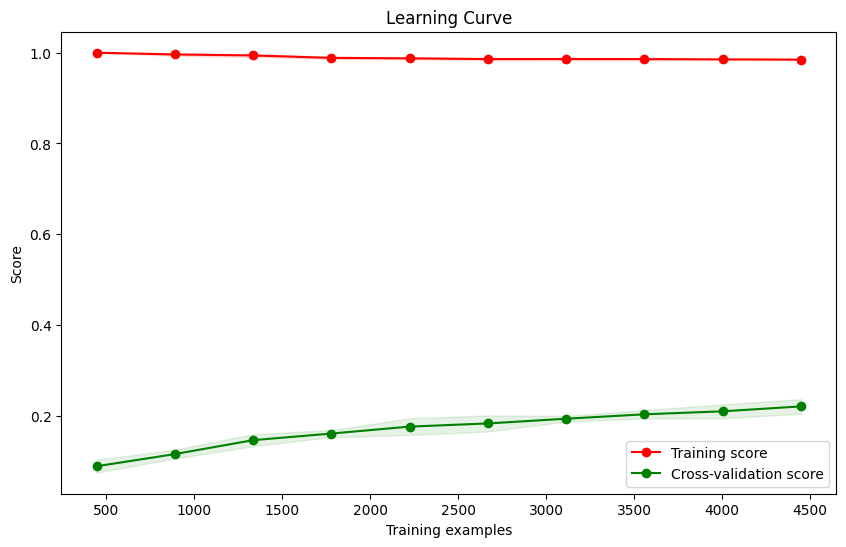


Model Fit Assessment:
Train Accuracy: 0.9838
Validation Accuracy: N/A
Test Accuracy: 0.2642

Difference between Train and Test accuracy: 0.7197

Number of parameters: 44474200


In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder

# Load the dataset
data = pd.read_csv(r'C:\Biography\ArtEmotionalPalette-AI\PartA-model\datasets\x6perfect_cleaned_remove.csv')
X = data.iloc[:, 1:].values / 255.0  # Features (RGB values), normalized
y = data.iloc[:, 0].values # Target variable

# Encode labels
le = LabelEncoder()
y = le.fit_transform(y) # Transform string labels to numeric values

# Split the data into training and testing sets
# stratify=y ensures that the proportion of samples for each class is roughly the same in both train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)
y_pred_proba = rf_classifier.predict_proba(X_test) # Probability estimates for each class

# Evaluate the model
print("Model Evaluation:")
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (weighted): {precision:.4f}")
print(f"Recall (weighted): {recall:.4f}")
print(f"F1-score (weighted): {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")

# Perform cross-validation
cv_scores = cross_val_score(rf_classifier, X, y, cv=5)
print(f"\nCross-validation scores: {cv_scores}")
print(f"Mean CV score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion Matrix
plt.figure(figsize=(20, 16))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Learning Curve
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    rf_classifier, X, y, cv=5, n_jobs=-1, 
    train_sizes=np.linspace(0.1, 1.0, 10))

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.title("Learning Curve")
plt.legend(loc="best")
plt.show()

# Print overfitting/underfitting assessment
print("\nModel Fit Assessment:")
train_accuracy = rf_classifier.score(X_train, y_train)
test_accuracy = rf_classifier.score(X_test, y_test)
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: N/A")  # Random Forest doesn't have a separate validation set
print(f"Test Accuracy: {test_accuracy:.4f}")

print(f"\nDifference between Train and Test accuracy: {abs(train_accuracy - test_accuracy):.4f}")

if train_accuracy - test_accuracy > 0.1:
    print("Warning: Large gap between training and test accuracies suggests overfitting.")
elif train_accuracy < 0.8:
    print("Warning: Low training accuracy suggests underfitting.")
else:
    print("Model performance on training and test sets is consistent.")

# Model complexity
n_params = rf_classifier.n_estimators * np.sum([tree.tree_.node_count for tree in rf_classifier.estimators_])
print(f"\nNumber of parameters: {n_params}")

### Version 2 : Simple Random Forest for SMOTE dataset


Model Evaluation:


c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.8742
Precision (weighted): 0.8737
Recall (weighted): 0.8742
F1-score (weighted): 0.8699
ROC AUC Score: 0.9964

Cross-validation scores: [0.83522232 0.85527463 0.93548387 0.93315897 0.92761628]
Mean CV score: 0.8974 (+/- 0.0862)

Classification Report:
                 precision    recall  f1-score   support

       Abundant       0.78      1.00      0.88        21
         Active       0.86      0.90      0.88        21
          Adult       0.91      1.00      0.95        21
          Agile       0.95      0.95      0.95        22
       Alluring       0.86      0.90      0.88        21
        Amiable       0.95      1.00      0.98        21
        Amusing       0.87      1.00      0.93        20
   Aristocratic       0.96      1.00      0.98        22
       Aromatic       0.85      1.00      0.92        22
       Artistic       0.96      1.00      0.98        22
  Authoritative       0.88      1.00      0.93        21
         Bitter       0.85      1.00      0.92     

c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


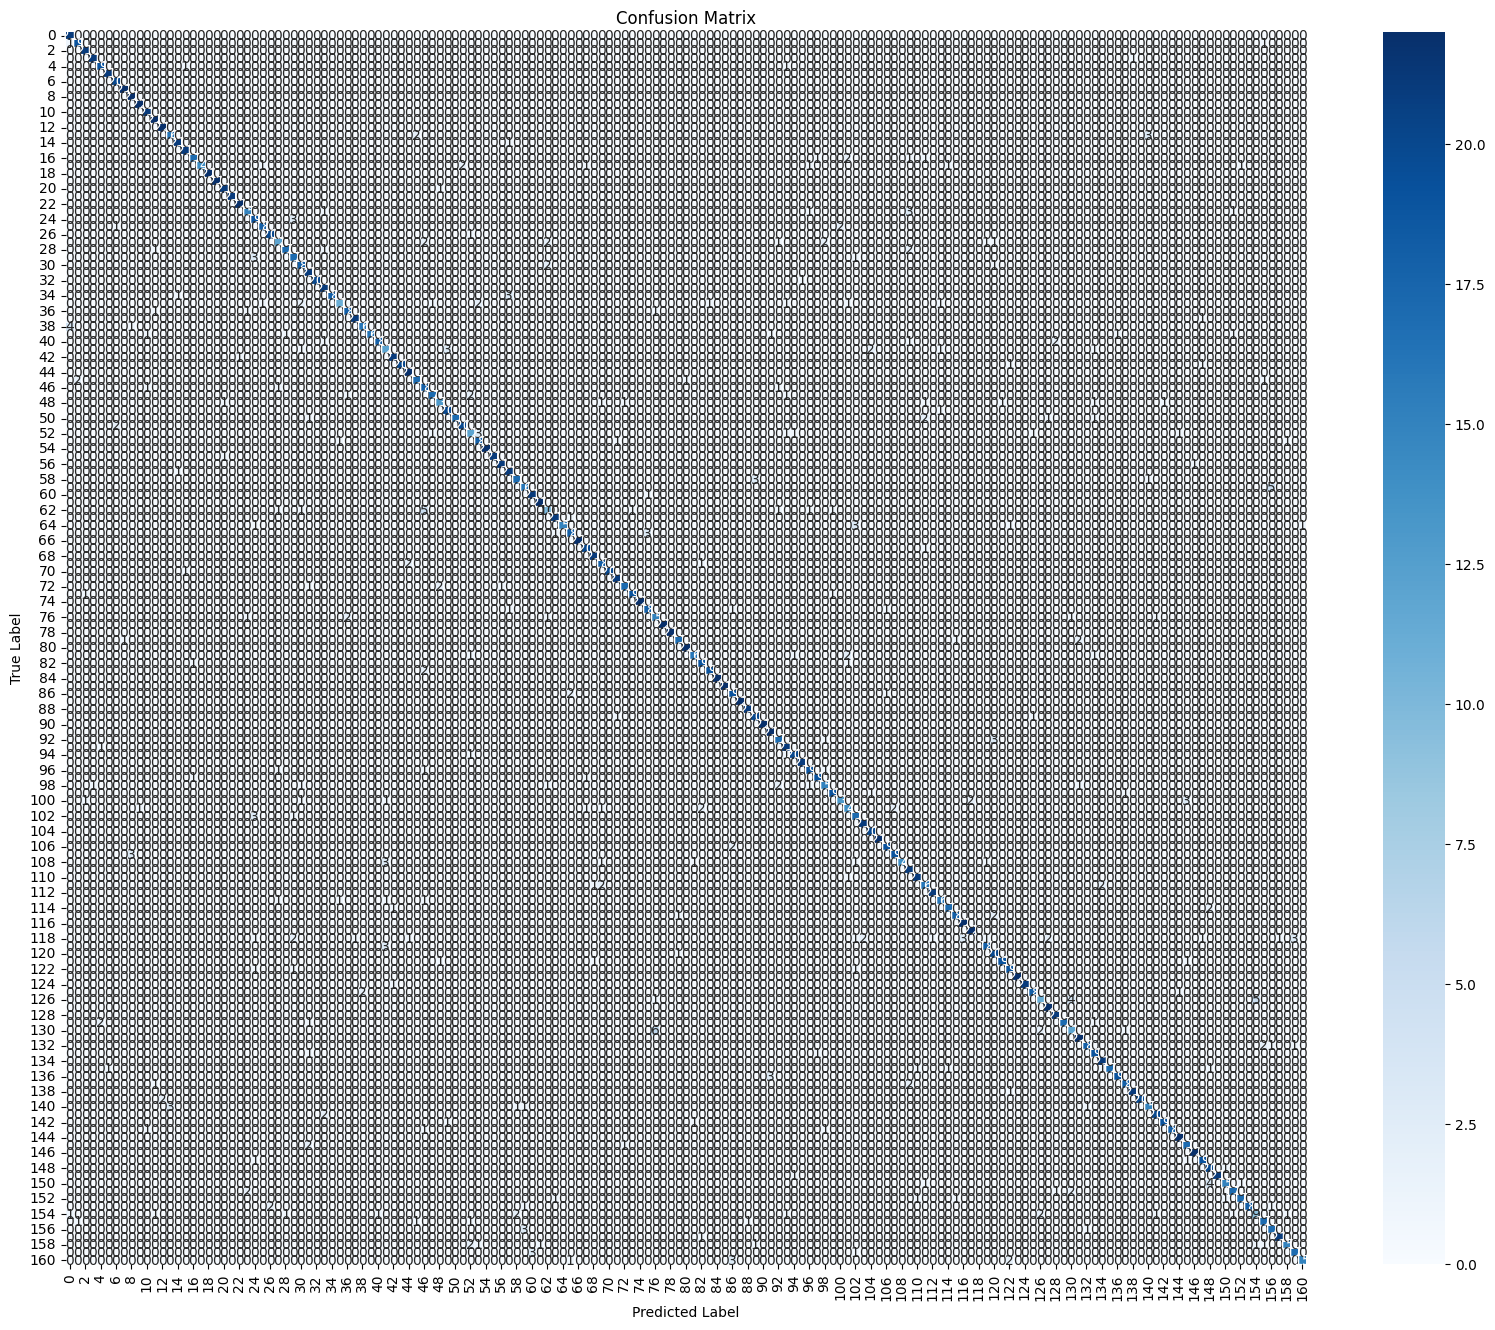

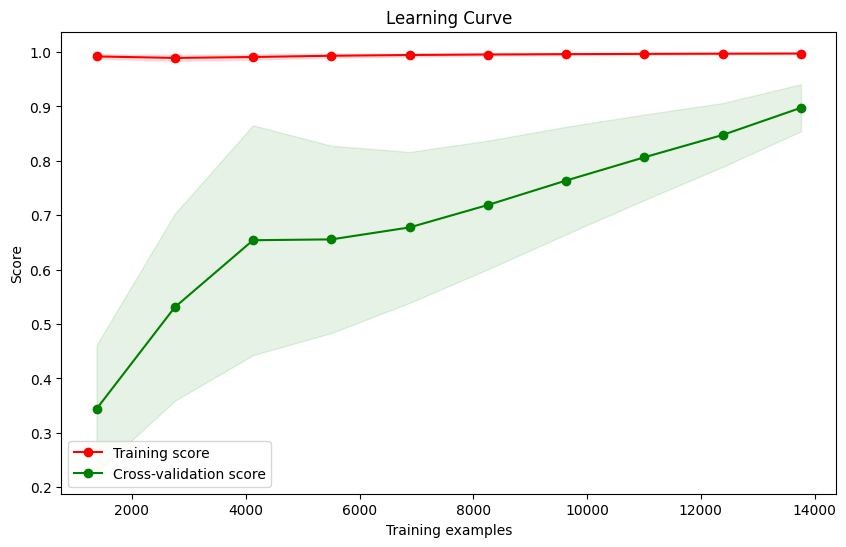


Model Fit Assessment:
Train Accuracy: 0.9976
Validation Accuracy: N/A
Test Accuracy: 0.8742

Difference between Train and Test accuracy: 0.1234

Number of parameters: 72391800


In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder

# Load the dataset
data = pd.read_csv('final_dataset.csv')
X = data.iloc[:, :-1].values / 255.0  # Features (RGB values), normalized
y = data.iloc[:, -1].values  # Target variable

# Encode labels
le = LabelEncoder()
y = le.fit_transform(y) # Transform string labels to numeric values

# Split the data into training and testing sets
# stratify=y ensures that the proportion of samples for each class is roughly the same in both train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)
y_pred_proba = rf_classifier.predict_proba(X_test) # Probability estimates for each class

# Evaluate the model
print("Model Evaluation:")
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (weighted): {precision:.4f}")
print(f"Recall (weighted): {recall:.4f}")
print(f"F1-score (weighted): {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")

# Perform cross-validation
cv_scores = cross_val_score(rf_classifier, X, y, cv=5)
print(f"\nCross-validation scores: {cv_scores}")
print(f"Mean CV score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion Matrix
plt.figure(figsize=(20, 16))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Learning Curve
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    rf_classifier, X, y, cv=5, n_jobs=-1, 
    train_sizes=np.linspace(0.1, 1.0, 10))

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.title("Learning Curve")
plt.legend(loc="best")
plt.show()

# Print overfitting/underfitting assessment
print("\nModel Fit Assessment:")
train_accuracy = rf_classifier.score(X_train, y_train)
test_accuracy = rf_classifier.score(X_test, y_test)
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: N/A")  # Random Forest doesn't have a separate validation set
print(f"Test Accuracy: {test_accuracy:.4f}")

print(f"\nDifference between Train and Test accuracy: {abs(train_accuracy - test_accuracy):.4f}")

if train_accuracy - test_accuracy > 0.1:
    print("Warning: Large gap between training and test accuracies suggests overfitting.")
elif train_accuracy < 0.8:
    print("Warning: Low training accuracy suggests underfitting.")
else:
    print("Model performance on training and test sets is consistent.")

# Model complexity
n_params = rf_classifier.n_estimators * np.sum([tree.tree_.node_count for tree in rf_classifier.estimators_])
print(f"\nNumber of parameters: {n_params}")

### Analysis of Random Forest Model:

1. Model Architecture:

- Number of trees (n_estimators): 100
- Feature selection: All features used (no explicit feature selection)
- Number of parameters: 72,391,800 (extremely high, indicating complex trees)

2. Performance Metrics:

- Test Accuracy: 0.8742 (87.42%)
- Precision (weighted): 0.8737 (87.37%)
- Recall (weighted): 0.8742 (87.42%)
- F1-score (weighted): 0.8699 (86.99%)
- ROC AUC Score: 0.9964 (99.64%)
- Train Accuracy: 0.9976 (99.76%)
- Mean Cross-Validation Score: 0.8974 (89.74%)

3. Hyperparameter Configuration:

- n_estimators: 100 (default)
- Other parameters likely at default values (e.g., max_depth=None, min_samples_split=2)

4. Training Process:

- Used 5-fold cross-validation

5. Generalization:

- Poor generalization evidenced by: Large gap between training accuracy (99.76%) and test accuracy (87.42%)
- Cross-validation score (89.74%) higher than test accuracy, indicating some instability

6. Learning curve shows:

- Near-perfect training scores across all training set sizes
- Improving but consistently lower cross-validation scores
- Persistent gap between training and cross-validation scores

7. Bias-Variance Trade-off:

- Very low bias: Extremely high training accuracy (99.76%) shows the model captures patterns in training data almost perfectly
- High variance: Large gap between training and test accuracies (12.34 percentage points) indicates poor generalization
- Bias estimate: 1 - Training Accuracy = 1 - 0.9976 = 0.0024 (0.24%)
- The model has extremely low bias (about 0.24%), meaning it learns the training data patterns almost perfectly. However, it fails to generalize well to new data, indicating severe overfitting.

8. Class Performance:

- Many classes show excellent performance (precision and recall > 0.90)
- Worst performing classes:
  - Pure_Simplicity: 0.00 (F1-score)
  - Untamed: 0.50 (F1-score)
  - Formal: 0.54 (F1-score)
  - Distinguished: 0.60 (F1-score)
  - Robust: 0.61 (F1-score)

9. Model Complexity:

- Extremely high number of parameters (72,391,800) suggests very deep and complex trees

10. Connfusion Matrix:

- Strong diagonal pattern indicates good overall classification
- Some off-diagonal elements suggest misclassifications between certain emotion pairs
- Detailed analysis of misclassifications could provide insights into similar emotions

11. ROC AUC Score:

- Very high score (0.9964) indicates excellent discriminative ability
- Suggests that despite overfitting, the model has learned meaningful patterns for ranking predictions

12. Cross-validation Stability:

- Cross-validation scores: [0.8352, 0.8553, 0.9355, 0.9332, 0.9276]
- Standard deviation: 0.0431 (4.31%)
- Indicates some variability in model performance across different subsets of the data

13. Overfitting Indicators:

- Large gap between train and test accuracy (12.34 percentage points)
- Near-perfect training accuracy (99.76%)
- Learning curve showing persistent gap between training and cross-validation scores

* Potentila Improvements
  limit tree depth, increase min_samples_leaf)
  Address class imbalance (e.g., class weighting, resampling techniques)
  Hyperparameter tuning using techniques like RandomizedSearchCV


### Version 3 : Advanced Random Forest


Performing Randomized Search for Random Forest...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Stratified K-Fold Cross-Validation Results:
CV Scores: [0.85631739 0.85152602 0.84939218 0.85046044 0.84623116]
Mean CV Score: 0.8508
Standard Deviation of CV Scores: 0.0033


c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: Unde


Final Model Results on Test Set:
Test Accuracy: 0.8782
Test Precision: 0.8773
Test Recall: 0.8782
Test F1-score: 0.8742
Train Accuracy: 0.9976

Classification Report (Test Set):
                 precision    recall  f1-score   support

       Abundant       0.83      0.95      0.89        21
         Active       0.77      0.95      0.85        21
          Adult       0.95      1.00      0.98        21
          Agile       0.95      0.95      0.95        22
       Alluring       0.87      0.95      0.91        21
        Amiable       0.91      1.00      0.95        21
        Amusing       0.87      1.00      0.93        20
   Aristocratic       1.00      1.00      1.00        22
       Aromatic       0.88      1.00      0.94        22
       Artistic       0.88      1.00      0.94        22
  Authoritative       0.95      1.00      0.98        21
         Bitter       0.88      1.00      0.94        22
        Bitterl       0.92      1.00      0.96        22
           Bold       

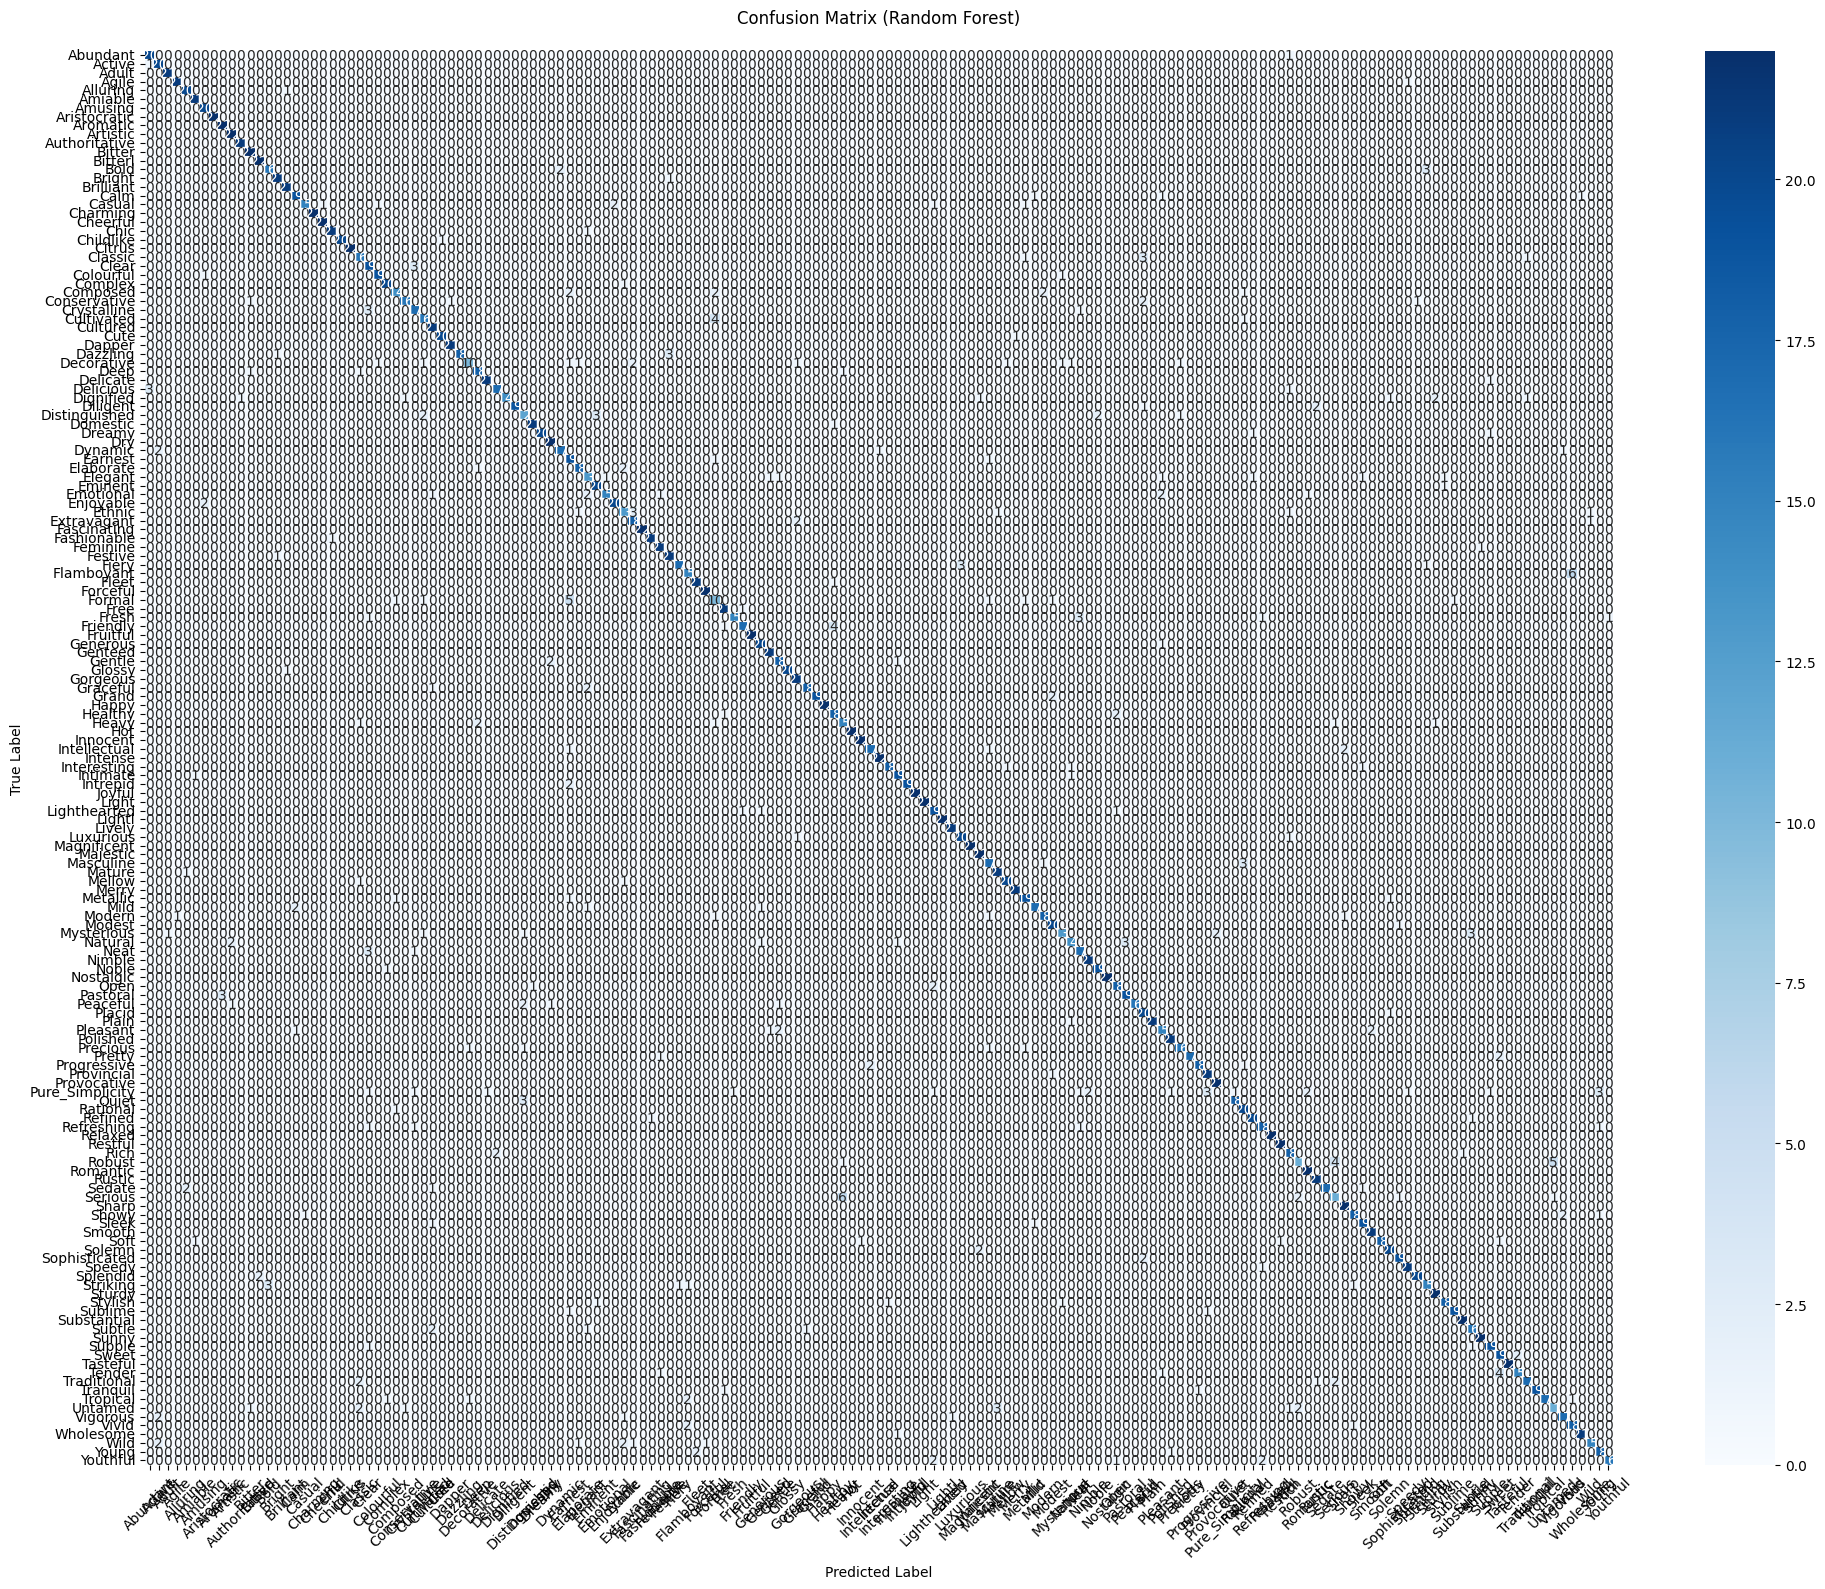

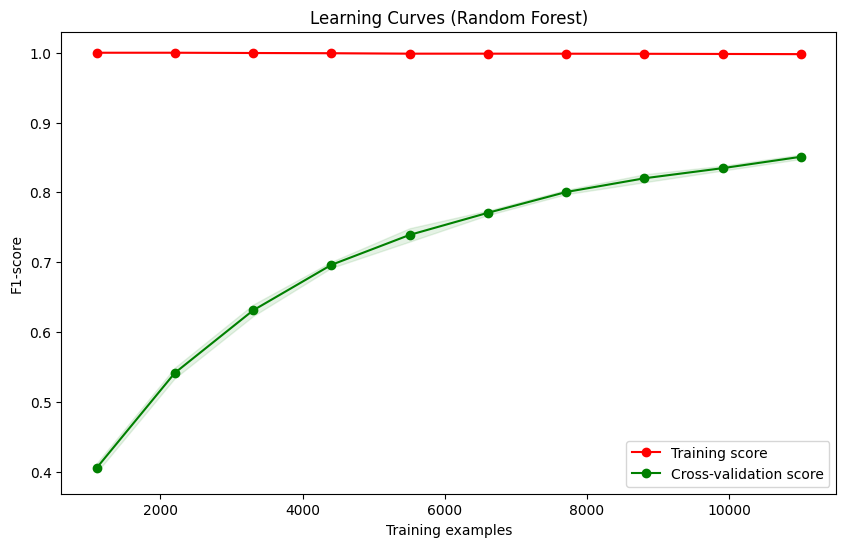

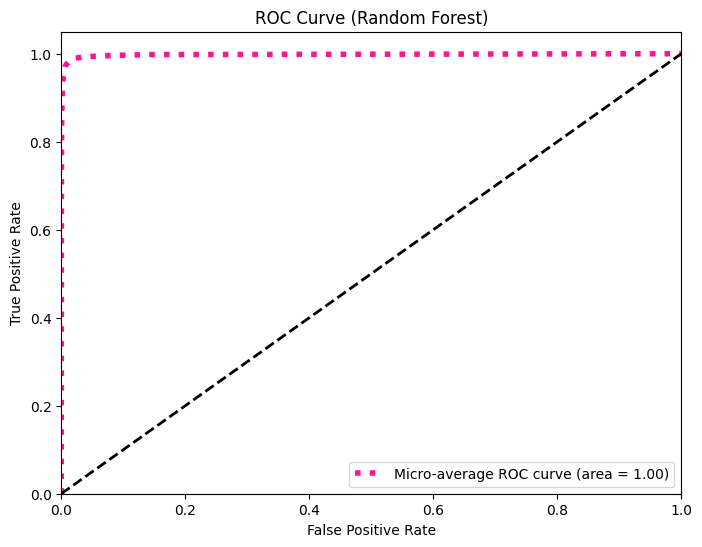

Model saved successfully to ../emotion-predictor/backend/app/model\random_forest_model.pkl


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, cross_val_score, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
import os
import pickle
import seaborn as sns
from sklearn.calibration import CalibratedClassifierCV

# 1. Load and preprocess the dataset
data = pd.read_csv('final_dataset.csv')
X = data.iloc[:, :-1].values / 255.0
y = data.iloc[:, -1].values

# Encode the target labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# 2. Define parameter grid for hyperparameter tuning
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'class_weight': ['balanced', 'balanced_subsample']
}

# 3. Set up RandomizedSearchCV
rf_classifier = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(estimator=rf_classifier, param_distributions=param_dist, n_iter=50, cv=5, n_jobs=-1, verbose=2, scoring='f1_weighted', random_state=42)

# 4. Perform Randomized Search to find the best hyperparameters
print("Performing Randomized Search for Random Forest...")
random_search.fit(X_train, y_train)

# 5. Get the best model
best_model = random_search.best_estimator_

# 6. Perform Stratified K-Fold Cross-Validation on the best model
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_model, X_train, y_train, cv=skf, scoring='f1_weighted')

# 7. Print cross-validation results
print("\nStratified K-Fold Cross-Validation Results:")
print(f"CV Scores: {cv_scores}")
print(f"Mean CV Score: {cv_scores.mean():.4f}")
print(f"Standard Deviation of CV Scores: {cv_scores.std():.4f}")

# 8. Fit the model on the entire training set
best_model.fit(X_train, y_train)

# 8+. Calibrate the pipeline using CalibratedClassifierCV
#    Here we use 5-fold for calibration; 'isotonic' typically works well for multi-class
calibrated_RF = CalibratedClassifierCV(
    estimator=best_model, 
    method='isotonic', 
    cv=5
)
calibrated_RF.fit(X_train, y_train)


# 9. Evaluate the final model on the test set and train set
y_pred_test = best_model.predict(X_test)
y_pred_train = best_model.predict(X_train)

# Test Metrics
test_accuracy = accuracy_score(y_test, y_pred_test)
test_precision = precision_score(y_test, y_pred_test, average='weighted')
test_recall = recall_score(y_test, y_pred_test, average='weighted')
test_f1 = f1_score(y_test, y_pred_test, average='weighted')

# Train Metrics
train_accuracy = accuracy_score(y_train, y_pred_train)

print("\nFinal Model Results on Test Set:")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1-score: {test_f1:.4f}")
print(f"Train Accuracy: {train_accuracy:.4f}")

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred_test, target_names=le.classes_))

# 10. Confusion Matrix
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(20, 16))
sns.heatmap(cm, 
            annot=True,        
            fmt='d',           
            cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.title('Confusion Matrix (Random Forest)', pad=20)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 11. Learning Curves
train_sizes, train_scores, test_scores = learning_curve(
    best_model, X_train, y_train, cv=skf, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), scoring='f1_macro'
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("F1-score")
plt.title("Learning Curves (Random Forest)")
plt.legend(loc="best")
plt.show()

# 12. ROC Curve
y_score = best_model.predict_proba(X_test)
n_classes = len(le.classes_)
fpr = dict()
tpr = dict()
roc_auc = dict()

y_bin = np.eye(n_classes)[y_test]
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure(figsize=(8, 6))
plt.plot(fpr["micro"], tpr["micro"],
         label='Micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Random Forest)')
plt.legend(loc="lower right")
plt.show()

# 13. Save the model and scaler
model_dir = '../emotion-predictor/backend/app/model'
os.makedirs(model_dir, exist_ok=True)

# Save the model using pickle
model_path = os.path.join(model_dir, 'random_forest_model.pkl')
with open(model_path, 'wb') as f:
    pickle.dump(best_model, f)
print(f"Model saved successfully to {model_path}")

# Save the label encoder
le_path = os.path.join(model_dir, 'label_encoder.pkl')
with open(le_path, 'wb') as f:     
    pickle.dump(le, f) 

### Calibrated Random Forest


In [ ]:
# Necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, cross_val_score, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
import os
import pickle
import seaborn as sns
from sklearn.calibration import CalibratedClassifierCV

# 1. Load and preprocess the dataset
data = pd.read_csv('final_dataset.csv')
X = data.iloc[:, :-1].values / 255.0
y = data.iloc[:, -1].values

# Encode the target labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# 2. Define parameter grid for hyperparameter tuning
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'class_weight': ['balanced', 'balanced_subsample']
}

# 3. Set up RandomizedSearchCV
rf_classifier = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(
    estimator=rf_classifier,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring='f1_weighted',
    random_state=42
)

# 4. Perform Randomized Search to find the best hyperparameters
print("Performing Randomized Search for Random Forest...")
random_search.fit(X_train, y_train)

# 5. Get the best model
best_model = random_search.best_estimator_

# 6. Fit the rf pipeline on the training data
best_model.fit(X_train, y_train)

# 7. Calibrate the pipeline using CalibratedClassifierCV
#    Here we use 5-fold for calibration; 'isotonic' typically works well for multi-class
calibrated_RF = CalibratedClassifierCV(
    estimator=best_model, 
    method='isotonic', 
    cv=5
)
calibrated_RF.fit(X_train, y_train)

# 8. Predict on the test set
y_pred_test = calibrated_RF.predict(X_test)
y_proba_test = calibrated_RF.predict_proba(X_test)  # Calibrated probabilities

# 9. Evaluate
accuracy = accuracy_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test, average='weighted')
recall = recall_score(y_test, y_pred_test, average='weighted')
f1 = f1_score(y_test, y_pred_test, average='weighted')

print(f"Calibrated RF Test Accuracy: {accuracy:.4f}")
print(f"Calibrated RF Test Precision: {precision:.4f}")
print(f"Calibrated RF Test Recall: {recall:.4f}")
print(f"Calibrated RF Test F1-score: {f1:.4f}")

# 10. Classification report
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred_test, target_names=le.classes_))

# 11. Save your calibrated model
model_dir = '../emotion-predictor/backend/app/model'
os.makedirs(model_dir, exist_ok=True)

model_path = os.path.join(model_dir, 'randomForest_model_calibrated.pkl')
with open(model_path, 'wb') as f:
    pickle.dump(calibrated_RF, f)
print(f"Calibrated RF model saved successfully to {model_path}")

# 12. Save the label encoder
le_path = os.path.join(model_dir, 'label_encoder_calibrated.pkl')
with open(le_path, 'wb') as f:
    pickle.dump(le, f)
print(f"Label Encoder saved successfully to {le_path}")

print("\nCalibrated RF model and label encoder saved.")

Performing Randomized Search for Random Forest...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Calibrated RF Test Accuracy: 0.8788
Calibrated RF Test Precision: 0.8800
Calibrated RF Test Recall: 0.8788
Calibrated RF Test F1-score: 0.8763

Classification Report (Test Set):
                 precision    recall  f1-score   support

       Abundant       0.87      0.95      0.91        21
         Active       0.77      0.95      0.85        21
          Adult       1.00      1.00      1.00        21
          Agile       0.95      0.91      0.93        22
       Alluring       0.79      0.90      0.84        21
        Amiable       1.00      1.00      1.00        21
        Amusing       0.87      1.00      0.93        20
   Aristocratic       1.00      1.00      1.00        22
       Aromatic       0.96      1.00      0.98        22
       Artistic       1.00      1.00      1.00        22
  Authoritative       0.95      1.00      0.98        21
         Bitter       1.0

OSError: [Errno 28] No space left on device